In [2]:
import cv2
import numpy as np
import tensorflow as tf
import glob

In [3]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
import warnings

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
import os   # accessing folder paths
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import patoolib  # This is useful to extract zip files 
import cv2,glob 
import shutil   # this module is used to do file accessing operations

In [5]:
classes = {1:'1',2:'2',3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8',
           9:'9',10:'A',11:'B',12:'C',13:'D',14:'E',15:'F',16:'G',17:'H',18:'I',
           19:'J',20:'K',21:'L',22:'M',23:'N',24:'O',25:'P',26:'Q',27:'R',28:'S',29:'T',30:'U',
           31:'V',32:'W',33:'X',34:'Y',35:'Z'}
words_data = {1:'All_The_Best', 2:'Hi!!', 3: 'I_Love_you', 4: 'No', 5:'Super!!', 6:'Yes'}

In [6]:
# create directory for dataset
# first create directories inthe name of class keys
# You need to run this only once.
print('Creating Folders for data. Please wait...')
for dir_name in classes.values():
    !mkdir {'G:\\gestures\\train\\' + dir_name}
    !mkdir {'G:\\gestures\\test\\' + dir_name}
print('Done.')

Creating Folders for data. Please wait...
A subdirectory or file G:\gestures\train\1 already exists.
A subdirectory or file G:\gestures\test\1 already exists.
A subdirectory or file G:\gestures\train\2 already exists.
A subdirectory or file G:\gestures\test\2 already exists.
A subdirectory or file G:\gestures\train\3 already exists.
A subdirectory or file G:\gestures\test\3 already exists.
A subdirectory or file G:\gestures\train\4 already exists.
A subdirectory or file G:\gestures\test\4 already exists.
A subdirectory or file G:\gestures\train\5 already exists.
A subdirectory or file G:\gestures\test\5 already exists.
A subdirectory or file G:\gestures\train\6 already exists.
A subdirectory or file G:\gestures\test\6 already exists.
A subdirectory or file G:\gestures\train\7 already exists.
A subdirectory or file G:\gestures\test\7 already exists.
A subdirectory or file G:\gestures\train\8 already exists.
A subdirectory or file G:\gestures\test\8 already exists.
A subdirectory or file

In [7]:
# creates data for words
# RUN THIS ONLY ONCE 
print('Creating Folders for words data. Please wait....')
for dir_name in words_data.values():
    !mkdir {'G:\\gestures\\words_data\\test\\' + dir_name}
    !mkdir {'G:\\gestures\\words_data\\train\\' + dir_name}
    
print('Done!!!')

Creating Folders for words data. Please wait....
A subdirectory or file G:\gestures\words_data\test\All_The_Best already exists.
A subdirectory or file G:\gestures\words_data\train\All_The_Best already exists.
A subdirectory or file G:\gestures\words_data\test\Hi!! already exists.
A subdirectory or file G:\gestures\words_data\train\Hi!! already exists.
A subdirectory or file G:\gestures\words_data\test\I_Love_you already exists.
A subdirectory or file G:\gestures\words_data\train\I_Love_you already exists.
A subdirectory or file G:\gestures\words_data\test\No already exists.
A subdirectory or file G:\gestures\words_data\train\No already exists.
A subdirectory or file G:\gestures\words_data\test\Super!! already exists.
A subdirectory or file G:\gestures\words_data\train\Super!! already exists.
A subdirectory or file G:\gestures\words_data\test\Yes already exists.
Done!!!
A subdirectory or file G:\gestures\words_data\train\Yes already exists.


In [32]:
background = None
accumulated_weight = 0.7
mask_color = (0.0,0.0,0.0)

ROI_top = 100
ROI_bottom = 300
ROI_right = 300
ROI_left = 500

In [25]:
# This function is used to calculate accumulated_weights in the frame
def cal_accum_avg(frame, accumulated_weight):

    global background
    
    if background is None:
        background = frame.copy().astype("float")
        return None

    cv2.accumulateWeighted(frame, background, accumulated_weight)

In [26]:
# This function segments the hand region found in the frame, if not found returns None.
def segment_hand(frame, threshold=50):
    global background
    
    diff = cv2.absdiff(background.astype("uint8"), frame)

    
    _ , thresholded = cv2.threshold(diff, threshold, 255,cv2.THRESH_BINARY)
    
    edges = cv2.Canny(thresholded, threshold1= 50, threshold2=250)
    cv2.imshow('edges',thresholded)
    
     #Fetching contours in the frame (These contours can be of hand
    #or any other object in foreground) …

    contours, hierarchy = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    # If length of contours list = 0, means we didn't get any
    #contours...
    if len(contours) == 0:
        return None
    else:
        # The largest external contour should be the hand
        # contour_info = [(c, cv2.contourArea(c),) for c in contours[1]]

        #cntrs, heirs = cv2.findContours(thresholded.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

        contour_info = [(c, cv2.contourArea(c),) for c in contours]
        #for c in contours[1]:
        #    contour_info.append((c,cv2.contourArea(c),))
        
        hand_segment_max_cont = max(contours, key=cv2.contourArea)
        
        # Returning the hand segment(max contour) and the
  # thresholded image of hand and contour_info list
    return (thresholded, hand_segment_max_cont, contour_info)

In [10]:
## Initialize tbase dir, train_dir, test_dir
base_dir = 'G:\\gestures\\words_data\\'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir,'test')

# Here we create the data_set for word recognition

In [11]:
import time
for element in words_data.values():
    cam = cv2.VideoCapture(0)
    num_frames = 0
    num_imgs_taken = 0
    time.sleep(5)
    print('#################################################')
    print(f'Show sign for {element}!')

    print(f'Creating data for {element}.....')
    
    while True:
        ret, frame = cam.read()

        # flipping the frame to prevent inverted image of captured frame...
        frame = cv2.flip(frame, 1)

        frame_copy = frame.copy()

        roi = frame[ROI_top:ROI_bottom, ROI_right:ROI_left]

        gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)

        if num_frames < 60:
            cal_accum_avg(gray_frame, accumulated_weight)
            if num_frames <= 59:
                cv2.putText(frame_copy, "FETCHING BACKGROUND...PLEASE WAIT",
                            (80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
                
        #Time to configure the hand specifically into the ROI...
        elif num_frames <= 300: 

            hand = segment_hand(gray_frame)
            cv2.putText(frame_copy, "Adjust hand gesture for..",
                            (200, 400), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 1, (0,0,255), 2)
                
            if hand is not None:
                
                thresholded, hand_segment, contour_info = hand

                # Draw contours around hand segment
                cv2.drawContours(frame_copy, [hand_segment + (ROI_right,
                ROI_top)], -1, (255, 0, 0),1)
                
                cv2.putText(frame_copy, str(num_frames)+"For" + str(element),
                            (70, 45), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 1, (0,0,255), 2)

                # Also display the thresholded image
                cv2.imshow("Thresholded Hand Image", thresholded)
        
        else: 
            
            # Segmenting the hand region...
            hand = segment_hand(gray_frame)
            
            # Checking if we are able to detect the hand...
            if hand is not None:
                
                # unpack the thresholded img and the max_contour...
                thresholded, hand_segment,contour_info = hand

                # Drawing contours around hand segment
                cv2.drawContours(frame_copy, [hand_segment + (ROI_right,
                ROI_top)], -1, (255, 0, 0),1)
                
                cv2.putText(frame_copy, str(num_frames), (70, 45),cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
                
                cv2.putText(frame_copy,"Adjust hand gesture for..",(200, 400),cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 1,(0,0,                              255)                                                                                                                   , 2)
                # Displaying the thresholded image
                cv2.imshow("Thresholded Hand Image", thresholded)
                if num_imgs_taken <= 70:
                    cv2.imwrite("G:\\gestures\\words_data\\test\\"+str(element)+"\\" + str(num_imgs_taken) + '.jpg',                                   thresholded)
                else:
                    break
                num_imgs_taken +=1
            else:
                cv2.putText(frame_copy, 'No hand detected...', (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)



        # Drawing ROI on frame copy
        cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right,ROI_bottom), (255,128,0), 3)
        
        cv2.putText(frame_copy, "Sign languge recognition_ _ _", (10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
        
        # increment the number of frames for tracking
        num_frames += 1

        # Display the frame with segmented hand
        cv2.imshow("Sign Detection", frame_copy)

        # Closing windows with Esc key...(any other key with ord can be used too.)
        k = cv2.waitKey(1) & 0xFF

        if k == 27:
            break

    # Releasing the camera & destroying all the windows...

    cv2.destroyAllWindows()
    cam.release()
    
    print('Done!')

#################################################
Show sign for Hi!!!
Creating data for Hi!!.....
Done!
#################################################
Show sign for I_Love_you!
Creating data for I_Love_you.....
Done!
#################################################
Show sign for Yes!
Creating data for Yes.....
Done!
#################################################
Show sign for No!
Creating data for No.....
Done!
#################################################
Show sign for Super!!!
Creating data for Super!!.....
Done!
#################################################
Show sign for All_The_Best!
Creating data for All_The_Best.....
Done!


In [61]:
cam.release()

# Create image data generators for test and train batches

In [11]:
# This cell creates data generators for train and test images.
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)                 .flow_from_directory(directory=train_dir, target_size=(64,64), class_mode='categorical', batch_size=10,shuffle=True)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_dir, target_size=(64,64), class_mode='categorical', batch_size=10, shuffle=True)

Found 4206 images belonging to 6 classes.
Found 426 images belonging to 6 classes.


# Plot few images to check

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

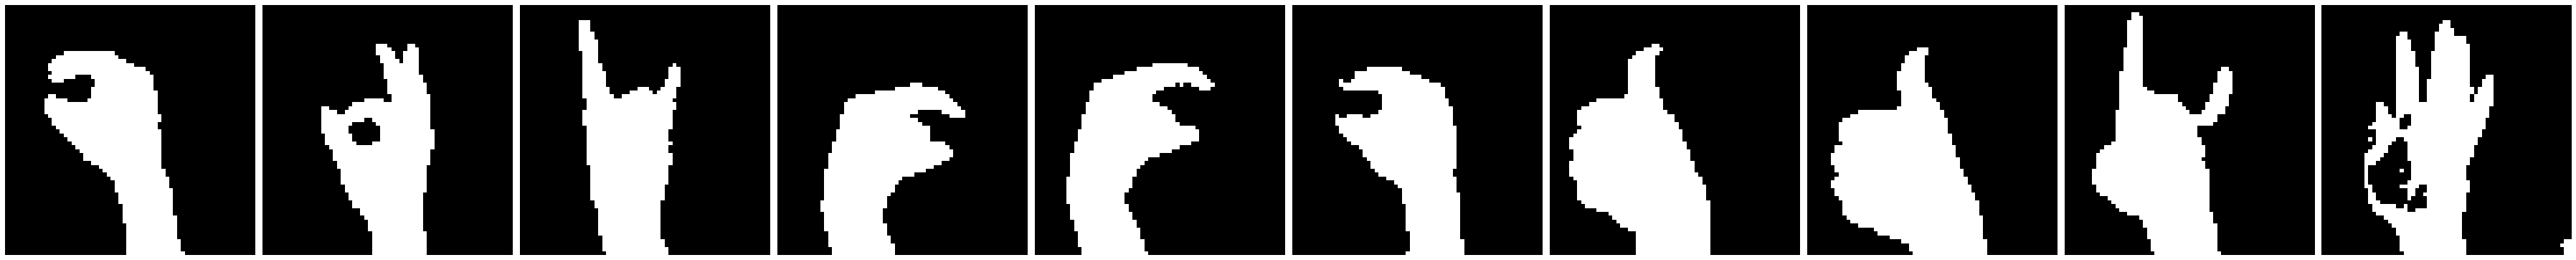

Actual labels:
No  Super!!  I_Love_you  No  No  No  All_The_Best  All_The_Best  I_Love_you  Hi!!  

In [12]:
imgs, labels = next(train_batches)
print(words_data)
#Plotting the images...
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(50,50))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


plotImages(imgs)
print('Actual labels:')

for i in labels:
    print(words_data[np.argmax(i) + 1],end = '  ')


# Initializing the SEQUENTIAL model

In [13]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64,64,3)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Flatten())

model.add(Dense(64,activation ="relu"))
model.add(Dense(128,activation ="relu"))
#model.add(Dropout(0.2))
model.add(Dense(128,activation ="relu"))
#model.add(Dropout(0.3))
model.add(Dense(6,activation ="softmax"))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 31, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0

In [15]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

In [18]:
history2 = model.fit(train_batches, epochs=25, callbacks=[reduce_lr, early_stop],  validation_data = test_batches)

Epoch 1/25
421/421 [==============================] - 30s 71ms/step - loss: 2.2056e-07 - accuracy: 1.0000 - val_loss: 1.0143 - val_accuracy: 0.7934
Epoch 2/25
421/421 [==============================] - 32s 75ms/step - loss: 1.5872e-07 - accuracy: 1.0000 - val_loss: 1.0166 - val_accuracy: 0.7887
Epoch 3/25
421/421 [==============================] - 32s 75ms/step - loss: 1.2828e-07 - accuracy: 1.0000 - val_loss: 1.0112 - val_accuracy: 0.7887
Epoch 4/25
421/421 [==============================] - 32s 75ms/step - loss: 1.1941e-07 - accuracy: 1.0000 - val_loss: 1.0097 - val_accuracy: 0.7887
Epoch 5/25
421/421 [==============================] - 32s 75ms/step - loss: 1.1107e-07 - accuracy: 1.0000 - val_loss: 1.0108 - val_accuracy: 0.7887
Epoch 6/25
421/421 [==============================] - 32s 76ms/step - loss: 1.0334e-07 - accuracy: 1.0000 - val_loss: 1.0098 - val_accuracy: 0.7887


## Here we print the accuracy of the model

In [19]:
# For getting next batch of testing imgs...
imgs, labels = next(test_batches) 

scores = model.evaluate(imgs, labels, verbose=0)
print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')


#Once the model is fitted we save the model using model.save()  function.


#model.save('best_model_dataflair3.h5')

loss of 0.825911819934845; accuracy of 89.99999761581421%


In [20]:
model.save('best_model.h5')

# Prediction with model

In [29]:
model = keras.models.load_model('best_model.h5')
background = None

In [50]:
cam = cv2.VideoCapture(0)
num_frames =0
while True:
    ret, frame = cam.read()

    # flipping the frame to prevent inverted image of captured
    #frame...
    
    frame = cv2.flip(frame, 1)

    frame_copy = frame.copy()

    # ROI from the frame
    roi = frame[ROI_top:ROI_bottom, ROI_right:ROI_left]

    gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)


    if num_frames < 70:
        
        cal_accum_avg(gray_frame, accumulated_weight)
        
        cv2.putText(frame_copy, "FETCHING BACKGROUND...PLEASE WAIT",
  (80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
    
    else: 
        # segmenting the hand region
        hand = segment_hand(gray_frame)
        
        # Checking if we are able to detect the hand...
        if hand is not None:
            
            thresholded, hand_segment,contour_info = hand

            # Drawing contours around hand segment
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right,
      ROI_top)], -1, (255, 0, 0),1)
            
            cv2.imshow("Thesholded Hand Image", thresholded)
            
            thresholded = cv2.resize(thresholded, (64, 64))
            thresholded = cv2.cvtColor(thresholded,
 cv2.COLOR_GRAY2RGB)
            thresholded = np.reshape(thresholded,
(1,thresholded.shape[0],thresholded.shape[1],3))
            
            pred = model.predict(thresholded)
            cv2.putText(frame_copy, words_data[np.argmax(pred) + 1],
(300, 45), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 1, (0,0,255), 2)
            
    # Draw ROI on frame_copy
    cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right,
    ROI_bottom), (255,128,0), 3)

    # incrementing the number of frames for tracking
    num_frames += 1

    # Display the frame with segmented hand
    cv2.putText(frame_copy, "Indian sign language recognition_ _ _",
    (10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
    cv2.imshow("Sign Detection", frame_copy)


    # Close windows with Esc
    k = cv2.waitKey(1) & 0xFF

    if k == 27:
        break

# Release the camera and destroy all the windows
cam.release()
cv2.destroyAllWindows()

In [42]:
cam.release()

In [ ]:
# Importing the necessary module which is Opencv
import cv2 as cv
# Creating a cascade classifier object by passing the required path containg the haar cascades .xml files
face_cascade = cv.CascadeClassifier('hand.xml')

# Checks whether the path and cascade classifier was loaded correctly
test = face_cascade.load('palm.xml')

print(test)

if not face_cascade.empty():	# if the casecade object is not empty then continue with the processing
	#print(face_cascade.empty())
	img = cv.VideoCapture(0)	# Captures the video from the webcam/to load a video pass the video path
	while True:
		ret,frame = img.read()	# retrieves frames one by one from the webcam
		# ret is a flag which indicates whether the frame was retreived correctly
		frame = cv.flip(frame, 1)
		gray = cv.cvtColor(frame,cv.COLOR_BGR2GRAY)		# converts the rgb/bgr frame to gray for processing purposes 
		
		blured = cv.GaussianBlur(gray,(5,5),cv.BORDER_DEFAULT)	# blurs the gray image to improve detection
		
		faces = face_cascade.detectMultiScale(blured,1.2,9)		# returns the detected faces as rectangle co-ordinates

		for (x,y,w,h) in faces:
			cv.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)		# Draws retangle on the detected faces
		
		cv.imshow('Hand Detection',frame)			

		k = cv.waitKey(20) & 0xff
		if k==27:
			break
	img.release()
	cv.destroyAllWindows()

In [ ]:
cv2.__version__